# Introduction

This notebook presents **LSTM** network with character-wise input trained on Shakespeare plays.

Dataset file is included in this repo and consists of all works of Shakespeare concatenated together (4.6MB).

# Imports

In [1]:
import time
import collections
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Read Data

Dataset location

In [4]:
dataset_location = '../Datasets/shakespeare/shakespeare_input.txt'

Open text file

In [5]:
with open(dataset_location, 'r') as f:
    text = f.read()
print(text[:173])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.


Discard bit at the end such that text is divisible by 1024. This allow for batch sizes [1, 2, 4, 8, 16, 32, ..., 1024]

In [6]:
mod1024 = len(text) % 1024
text = text[:-mod1024]

Tokenize

In [7]:
tokens = collections.Counter(text).most_common()
tokens[0:5]

[(' ', 696165), ('e', 386342), ('t', 272672), ('o', 268956), ('a', 230593)]

In [8]:
i2c = {i : c for i, (c, n) in enumerate(tokens)}
c2i = {c : i for i, c in i2c.items()}
print('i2c:', i2c)
print('c2i:', c2i)

i2c: {0: ' ', 1: 'e', 2: 't', 3: 'o', 4: 'a', 5: 'h', 6: 's', 7: 'n', 8: 'r', 9: 'i', 10: '\n', 11: 'l', 12: 'd', 13: 'u', 14: 'm', 15: 'y', 16: ',', 17: 'w', 18: 'f', 19: 'c', 20: 'g', 21: 'I', 22: ':', 23: 'b', 24: 'p', 25: 'A', 26: '.', 27: 'v', 28: 'T', 29: 'k', 30: "'", 31: 'S', 32: 'E', 33: 'O', 34: 'N', 35: 'R', 36: 'L', 37: ';', 38: 'C', 39: 'H', 40: 'W', 41: 'M', 42: 'U', 43: 'B', 44: 'D', 45: '?', 46: 'F', 47: '!', 48: '-', 49: 'G', 50: 'P', 51: 'Y', 52: 'K', 53: 'V', 54: 'j', 55: 'q', 56: 'x', 57: 'J', 58: 'z', 59: 'Q', 60: 'Z', 61: 'X', 62: '3', 63: '&', 64: '[', 65: ']', 66: '$'}
c2i: {' ': 0, 'e': 1, 't': 2, 'o': 3, 'a': 4, 'h': 5, 's': 6, 'n': 7, 'r': 8, 'i': 9, '\n': 10, 'l': 11, 'd': 12, 'u': 13, 'm': 14, 'y': 15, ',': 16, 'w': 17, 'f': 18, 'c': 19, 'g': 20, 'I': 21, ':': 22, 'b': 23, 'p': 24, 'A': 25, '.': 26, 'v': 27, 'T': 28, 'k': 29, "'": 30, 'S': 31, 'E': 32, 'O': 33, 'N': 34, 'R': 35, 'L': 36, ';': 37, 'C': 38, 'H': 39, 'W': 40, 'M': 41, 'U': 42, 'B': 43, 'D': 44

Encode text as tokens, reshape to batches, convert to tensor

In [9]:
batch_size = 128

data = np.array([c2i[c] for c in text])
data = data.reshape((batch_size, -1))
print('data:')
print(data)
print('shape:', data.shape)

data:
[[46  9  8 ...  3  2  0]
 [ 9  7  0 ... 30  6 16]
 [ 0 17  4 ...  1 19  3]
 ...
 [43  8  3 ...  0  9  2]
 [ 0  9  7 ...  5  1  8]
 [ 0  2  5 ...  0  4  8]]
shape: (128, 35728)


In [10]:
split_index = int(data.shape[1]*.8)  # 80% train, 10% valid
train_data, valid_data = np.split(data, [split_index], axis=1)
print('train_data:', train_data.shape)
print('valid_data:', valid_data.shape)

train_data: (128, 28582)
valid_data: (128, 7146)


Move to GPU if possible

In [11]:
train_x = torch.tensor(train_data).to(device)
valid_x = torch.tensor(valid_data).to(device)
print('train_x:', train_x.shape)
print('valid_x:', valid_x.shape)

train_x: torch.Size([128, 28582])
valid_x: torch.Size([128, 7146])


Model

In [12]:
class CharRNN(nn.Module):
    
    def __init__(self, nb_layers, n_in, n_embed, n_hid, n_out, dropout):
        super(CharRNN, self).__init__()
        self.embed = nn.Embedding(num_embeddings=n_in, embedding_dim=n_embed)
        self.lstm = nn.LSTM(input_size=n_embed, hidden_size=n_hid, num_layers=nb_layers,
                           batch_first=True, dropout=dropout)
        self.drop = nn.Dropout(p=dropout)
        self.fc = nn.Linear(in_features=n_hid, out_features=n_out)
    
    def forward(self, x, hidden):
        x = self.embed(x)                   # shape [n_batch, n_seq, n_embed]
        x, hidden = self.lstm(x, hidden)    # shape [n_batch, n_seq, n_hid]
        x = self.drop(x)
        x = self.fc(x)                      # shape [n_batch, n_seq, n_out]
        return x, hidden
    
    def sample(self, inputs, hidden, topk=5):
        """Sample one token, conditioned on inputs and hidden
        
        Params:
            inputs - tensor with input tokens, shape [1, n_seq]
            hidden - hidden state for LSTM, can be None
            topk - int, how many top choices to consider when sampling
        
        Returns:
            token for next predicted character, tensor of shape [1, 1] containing one int
        """
        logits, hidden = self(inputs, hidden)

        last_output = logits[0, -1]            # keep last seq. output       shape [n_out]
        probs = F.softmax(last_output, dim=0)  # logits to probabilities     shape [n_out]

        probs, indices = probs.topk(topk)
        weights = probs / probs.sum()                             # normalize probs
        tok = np.random.choice(a=indices.detach().cpu().numpy(),  # no torch impl. yet :(
                               p=weights.detach().cpu().numpy())

        res = torch.tensor([[tok]], device=inputs.device)    # feed to next sample() call
        return res, hidden

Hyperparameters

In [13]:
nb_layers = 2
n_in = len(i2c)
n_seq = 256
n_embed = 50
n_hid = 64
n_out = len(i2c)
dropout = .5

Create model

In [14]:
model = CharRNN(nb_layers, n_in, n_embed, n_hid, n_out, dropout)
model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Helper to generate new text

In [15]:
def generate(prompt=' ', size=1000):
    
    model.eval()

    inputs = [c2i[c] for c in prompt]               # tokenize
    inputs = torch.tensor(inputs).to(device)
    inputs = inputs.reshape(1, -1)                  # shape [n_batch=1, n_seq]

    result = []

    with torch.no_grad():
        output, hidden = model.sample(inputs, None, topk=5)
        result.append(output.item())

        for i in range(size-1):
            output, hidden = model.sample(output, hidden, topk=5)
            result.append(output.item())
            
    return ''.join([i2c[i] for i in result])

Helper function for training

In [16]:
def train(nb_epochs, trace, trace2):

    epoch = len(trace['epoch'])
    train_size = train_x.shape[1] - 1  # -1 because inputs/targets are shifted by one
    valid_size = valid_x.shape[1] - 1

    for _ in range(nb_epochs):

        time_start = time.time()

        #
        #   Train Model
        #
        model.train()
        tloss_sum = 0
        hidden = None                                  # reset LSTM hidden state
        for i in range(0, train_size, n_seq):

            # Pick mini-batch (over seqence dimension)
            inputs = train_x[:,i:i+n_seq]        # [n_batch, n_seq], less for last batch
            targets = train_x[:,i+1:i+1+n_seq]   # [n_batch, n_seq], less for last batch
            if inputs.shape[1] != targets.shape[1]:
                inputs = inputs[:,:-1]           # fix shape for last batch in epoch

            # Optimize
            optimizer.zero_grad()
            outputs, hidden = model(inputs, hidden)
            hidden = tuple(h.detach() for h in hidden)
            loss = criterion(outputs.view(-1, n_out), targets.flatten())
            loss.backward()
            optimizer.step()

            # Record per-iteration loss
            tloss_sum += loss.item() * inputs.shape[1]  # size of minibatch
            trace2['loss'].append( loss.item() )

        tloss_avg = tloss_sum / train_size

        #
        #   Evaluate Model
        #
        model.eval()
        vloss_sum = 0
        hidden = None
        with torch.no_grad():        
            for i in range(0, valid_size, n_seq):

                # Pick mini-batch
                inputs = valid_x[:,i:i+n_seq]
                targets = valid_x[:,i+1:i+1+n_seq]
                if inputs.shape[1] != targets.shape[1]:
                    inputs = inputs[:,:-1]

                # Optimize
                outputs, hidden = model(inputs, hidden)
                loss = criterion(outputs.view(-1, n_out), targets.flatten())

                # Record per-iteration loss
                vloss_sum += loss.item() * inputs.shape[1]

        vloss_avg = vloss_sum / valid_size

        #
        #   Logging
        #

        time_delta = time.time() - time_start

        trace['epoch'].append(epoch)
        trace['tloss'].append(tloss_avg)
        trace['vloss'].append(vloss_avg)
        
        #
        #   Print loss
        #
        print(f'Epoch: {epoch:3}     '
              f'T/V Loss: {tloss_avg:.4f} / {vloss_avg:.4f}     '
              f'Time: {time_delta:.2f}s')

        epoch += 1

Test model before training

In [17]:
prompt = 'KING:\n'
new_text = generate(prompt, size=1000)
print(prompt, new_text, sep='')

KING:
DNDDocNNDN3N3NQQQccDDoNoNNNNoN;NQNNDDo;QDNoDooWD-DN33QDDNNDQoQDNDQNooW3QNQQWoNDDDQoDNoooWN-o---oDWNN-NQ3N3oNNoNoN;QN3QWoDQcDNQooNW3NN3NDNoNooQNQQ3QWo3N3DNNDoQQDWcoNNQDNNoDo;NN3No;DD33N3QQoQcQcDoDcQ3c;Qc;D33DDD3DoN3o;DDoooNDNDo;N-QQocooNQWQQQ3cQWo3QD3QcocDDD3oNQDQoQoWNQ3NQoWNQNQ3D3o;DQNND33NQDoQDQQcQDcoNDD3Q3N3;oNN3QQcDQooNooNNNQ3;DNDoQcNDQ3DQQ3QcDc;DDco;QND3NNN3oQN3QW3oNDDDND3QQ3ccD;coDoN3NQD3DN3o;oQoDNoD;oWNDQQcNDNQcQ3ooW3DQ3o;oQoQQQWoNDND3oD;QN3DQN3NDoNo;QNoNoDNDQDQ3oDQN3N3QNDoQcDDN3DQoN3NooNoN;Q-Q--oDNoWQQoNQQQQdcDcQ3;33;oQoDQQooDNNDDDo;NNQN3QDN33N3QNDNDN3QDNQQcQDcoNoQNW3oNDDN3QD3DNDDQ3NNQNDoDNDoDQoNNDN3N3oooN;NQ-NDo;ooDDNo;--oQooooNoWooooQNNWQoQWD3Q3oW3BQDQQQ3oNNNQoNDDQN3QoWoDDDNDDNQNQcoooW3;DQQWQcQoQDQWQooQWQWDoNNDNoQDDoNooW3oNDDD3QoNNNoQNoNDQoQoNQQQcWNo3DQQQ3cc;oNoQQDQ3ccD;Q33NNDoo;-oND-QoWN3NoD;NQNDQ33QoDDDoND3o;-QNDNoNDQQQQQdWccQoNQQ3coQQD3NNNQNDD3QQ3ooQW3oWoQNNoDDNDNQNo3QWNQQQWNNoQoNNDDNDND3oooQDNDoooWDaDDDao3NDDNo3;NNoNNNNDQQNQoQW3DDoDoQQDW3NQN3Q3;3;3DQQ33ooWoNDoNDooQQW

Actually train the model

In [18]:
trace = {'epoch': [], 'tloss': [], 'vloss': []}    # per epoch
trace2 = {'loss' : []}                             # per iteration
train(nb_epochs=10, trace=trace, trace2=trace2)

Epoch:   0     T/V Loss: 3.3968 / 2.9009     Time: 6.48s
Epoch:   1     T/V Loss: 2.7400 / 2.4593     Time: 5.88s
Epoch:   2     T/V Loss: 2.5113 / 2.3201     Time: 5.31s
Epoch:   3     T/V Loss: 2.4156 / 2.2397     Time: 5.83s
Epoch:   4     T/V Loss: 2.3521 / 2.1786     Time: 5.57s
Epoch:   5     T/V Loss: 2.3021 / 2.1284     Time: 5.30s
Epoch:   6     T/V Loss: 2.2618 / 2.0863     Time: 5.64s
Epoch:   7     T/V Loss: 2.2285 / 2.0522     Time: 5.98s
Epoch:   8     T/V Loss: 2.2003 / 2.0229     Time: 5.90s
Epoch:   9     T/V Loss: 2.1746 / 1.9946     Time: 5.97s


Train some more

In [19]:
train(nb_epochs=10, trace=trace, trace2=trace2)

Epoch:  10     T/V Loss: 2.1504 / 1.9666     Time: 6.12s
Epoch:  11     T/V Loss: 2.1284 / 1.9454     Time: 6.75s
Epoch:  12     T/V Loss: 2.1110 / 1.9271     Time: 5.48s
Epoch:  13     T/V Loss: 2.0962 / 1.9119     Time: 5.53s
Epoch:  14     T/V Loss: 2.0826 / 1.8960     Time: 5.62s
Epoch:  15     T/V Loss: 2.0707 / 1.8826     Time: 5.45s
Epoch:  16     T/V Loss: 2.0598 / 1.8713     Time: 5.99s
Epoch:  17     T/V Loss: 2.0493 / 1.8596     Time: 6.31s
Epoch:  18     T/V Loss: 2.0407 / 1.8500     Time: 6.18s
Epoch:  19     T/V Loss: 2.0317 / 1.8403     Time: 6.10s


Test model after training

In [20]:
prompt = 'KING:\n'
new_text = generate(prompt, size=1000)
print(prompt, new_text, sep='')

KING:
The shand horter. Where she me as moniest
Wather. I there our theand this stell.

BUSENS:
I'll my son, the that the singlest son and his siled him that than hin that
Thill so had serse the sous and me,
In sertong, what as the letter to that.
When and more as to say the wite thing thou made.

COMOTIO:
At were thee hor a masto worls the so to me
What him my mad thimken of the save, at and
Tand in and made thou strust hy, and this honeth.
All and wall, here as will and mern with
That, this stones in that that thy misiting.

CAMENIO:
Thy sorsirom the she thou.

PILIUCE:
Which a stoness as so so sone, to thit this
thou sorsor and she hath then, that,
And the share of morithire to the meen, the mond that
In will thy mert, sead hone the wertertes,
And the some and she wall hightist,
The montute in his stirne as home to an hig of stiry
And the well to sard as a mind of my word the thee
to him have the mady thits have, say.

SIR ANTANE:
We had and we seint and mestath;
Where shas and mes 

# Train and Valid Loss

Wait, wait, wait, is valid loss less than train loss?

Lets plot per-iteration train loss

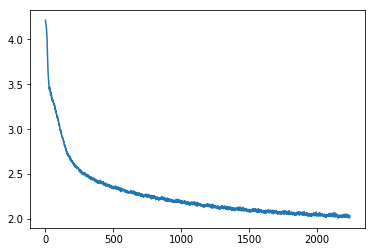

In [21]:
plt.plot(trace2['loss']);

Plot per-epoch train and valid losses

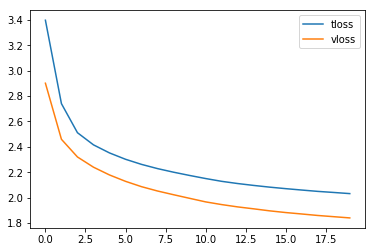

In [22]:
plt.plot(trace['tloss'], label='tloss')
plt.plot(trace['vloss'], label='vloss')
plt.legend();

**Why validation loss is less than train loss?**

Mainly because dropout is enabled in train mode.

To test this let's make helper function to evaluate model

In [23]:
def evaluate(data_x):
    
    data_size = data_x.shape[1] - 1
    
    #
    #   Evaluate Model
    #
    model.eval()
    loss_sum = 0
    hidden = None
    with torch.no_grad():        
        for i in range(0, data_size, n_seq):

            # Pick mini-batch
            inputs = data_x[:,i:i+n_seq]
            targets = data_x[:,i+1:i+1+n_seq]
            if inputs.shape[1] != targets.shape[1]:
                inputs = inputs[:,:-1]

            # Optimize
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs.view(-1, n_out), targets.flatten())

            # Record per-iteration loss
            loss_sum += loss.item() * inputs.shape[1]

    loss_avg = loss_sum / data_size
    
    return loss_avg

Evaluate on both train and valid datasets

In [24]:
train_loss = evaluate(train_x)
valid_loss = evaluate(valid_x)
print('train loss:', train_loss)
print('valid loss:', valid_loss)

train loss: 1.838507782494912
valid loss: 1.8403298074169707


Nope, all is good